In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

data = pd.read_csv("operations.csv")
data.head()

,date_operation,libelle,montant,solde_avt_ope,categ
0,2023-03-31,DON XX XX XX XX XX XX XX,-1.44,1515.25,AUTRE
1,2023-04-03,CARTE XX XX RAPT XX,-24.00,1513.81,TRANSPORT
2,2023-04-03,CARTE XX XX RAPT XX,-73.00,1489.81,TRANSPORT
3,2023-04-03,VIREMENT XX XX XX XX XX XX XX XX XX XX XX XX,676.00,1416.81,AUTRE
4,2023-04-03,VIREMENT XX XX XX XX XX XX,4.80,2092.81,AUTRE


## Représentez la distribution empirique d'une variable

### Variable qualitatives

Une variable qualitative est soit nominale soit ordinale.
- Ordinal si on peut l'ordonnée (un, deux, trois)
- Nominal si on ne peut pas l'ordonnée (rectangle, triangle, ...)

Une date est une variable qualitative ordinale car on n'additionne pas des dates en général, même pour un timestamp.

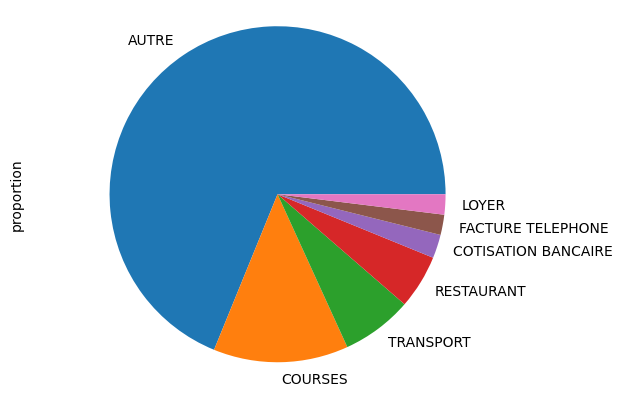

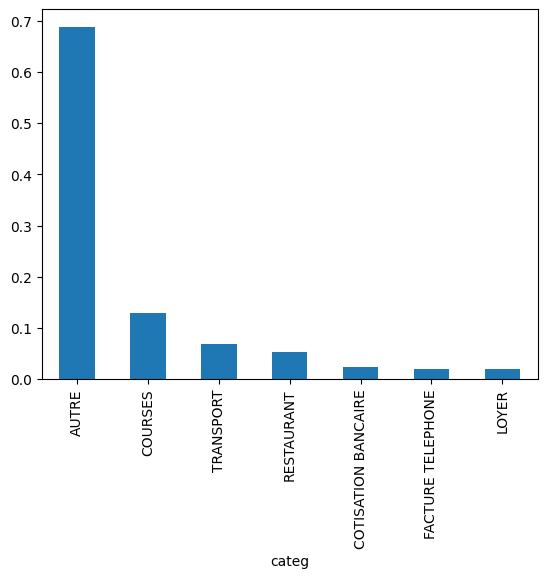

In [2]:
# Diagramme en secteurs
data["categ"].value_counts(normalize=True).plot(kind='pie')
# Cette ligne assure que le pie chart est un cercle plutôt qu'une éllipse
plt.axis('equal') 
plt.show() # Affiche le graphique

# Diagramme en tuyaux d'orgues
data["categ"].value_counts(normalize=True).plot(kind='bar')
plt.show()


### Variable quantitatives

Une variable qualitatives est soit discrète, soit continue.
- Continue, contient une infinité de possibilités,
- Discrète, contient un nombre de possibilité fini.


#### Variable discrètes

Correction du format de date pour éviter l'erreur: "Can only use .dt accessor with datetimelike values"

In [3]:
data['date_operation'] = pd.to_datetime(data['date_operation'], errors='coerce')

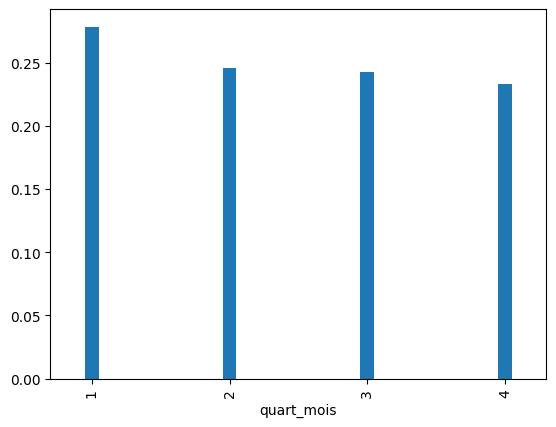

In [4]:
data['quart_mois'] = [int((jour-1)*4/31)+1 for jour in data["date_operation"].dt.day]
# Diagramme en bâtons
data["quart_mois"].value_counts(normalize=True).plot(kind='bar',width=0.1)
plt.show()

#### Variables continues

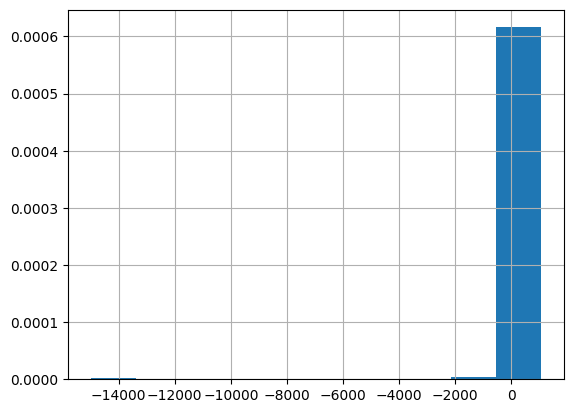

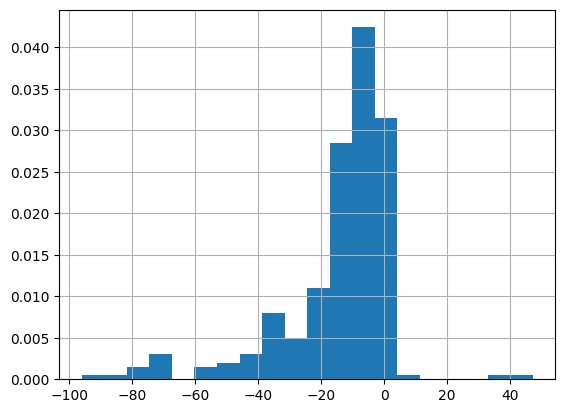

In [5]:
# Histogramme
data["montant"].hist(density=True)
plt.show()

# Histogramme plus beau
data[data.montant.abs() < 100]["montant"].hist(density=True,bins=20)
plt.show()

## Représentez les variables sous forme de tableau

In [6]:
effectifs = data["quart_mois"].value_counts()
modalites = effectifs.index # l'index de effectifs contient les modalités

tab = pd.DataFrame(modalites, columns = ["quart_mois"]) # création du tableau à partir des modalités
tab["n"] = effectifs.values
tab["f"] = tab["n"] / len(data) # len(data) renvoie la taille de l'échantillon

tab = tab.sort_values("quart_mois") # tri des valeurs de la variable X (croissant)
tab["F"] = tab["f"].cumsum() # cumsum calcule la somme cumulée

tab

,quart_mois,n,f,F
0,1,86,0.278317,0.278317
1,2,76,0.245955,0.524272
2,3,75,0.242718,0.766990
3,4,72,0.233010,1.000000


## Découvrez les mesures de tendance centrale

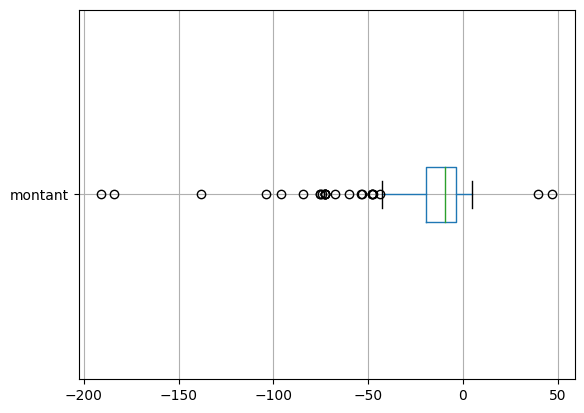

In [7]:
data[(data["montant"] > -200) & (data["montant"] < 200)].boxplot(column="montant", vert=False)
plt.show()

## Appréhendez les mesures de forme

Le Skewness empirique

Le skewness est une mesure d'asymétrie. L’asymétrie d’une distribution traduit la régularité (ou non) avec laquelle les observations se répartissent autour de la valeur centrale. On interprète cette mesure de cette manière :

Si γ1=0
 alors la distribution est symétrique.

Si γ1>0
 alors la distribution est étalée à droite.

Si γ1<0
 alors la distribution est étalée à gauche.

In [8]:
data['montant'].skew()

-16.42821460420292

Le Kurtosis empirique

Le kurtosis empirique n'est pas une mesure d'asymétrie, mais c'est une mesure d'aplatissement. L’aplatissement peut s’interpréter à la condition que la distribution soit symétrique. En fait, on compare l'aplatissement par rapport à la distribution la plus célèbre, appelée distribution normale (parfois "courbe de Gauss" ou "Gaussienne").

In [9]:
data['montant'].kurtosis()

282.31637060086683

In [10]:
## Familiarisez-vous avec les mesures de concentration

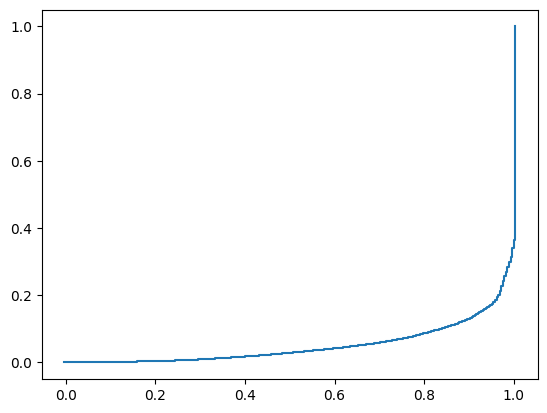

In [11]:
depenses = data[data['montant'] < 0]
dep = -depenses['montant'].values
n = len(dep)
lorenz = np.cumsum(np.sort(dep)) / dep.sum()
lorenz = np.append([0],lorenz) # La courbe de Lorenz commence à 0

xaxis = np.linspace(0-1/n,1+1/n,n+1) #Il y a un segment de taille n pour chaque individu, plus 1 segment supplémentaire d'ordonnée 0. Le premier segment commence à 0-1/n, et le dernier termine à 1+1/n.
plt.plot(xaxis,lorenz,drawstyle='steps-post')
plt.show()

In [12]:
AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/n # Surface sous la courbe de Lorenz. Le premier segment (lorenz[0]) est à moitié en dessous de 0, on le coupe donc en 2, on fait de même pour le dernier segment lorenz[-1] qui est à moitié au dessus de 1.
S = 0.5 - AUC # surface entre la première bissectrice et le courbe de Lorenz
gini = 2*S
gini

0.8939852259967689

## Analysez la corrélation entre deux variables quantitatives

Le coefficient de Pearson est un indice reflétant une relation linéaire entre deux variables continues. Le coefficient de corrélation varie entre -1 et +1, 0 reflétant une relation nulle entre les deux variables, une valeur négative (corrélation négative) signifiant que lorsqu'une des variable augmente, l'autre diminue ; tandis qu'une valeur positive (corrélation positive) indique que les deux variables varient ensemble dans le même sens.

In [13]:
import scipy.stats as st

print(st.pearsonr(depenses["solde_avt_ope"],-depenses["montant"])[0])
print(np.cov(depenses["solde_avt_ope"],-depenses["montant"],ddof=0)[1,0])

0.034956797916183016
19929.94227639358


## Analysez deux variables quantitatives par régression linéaire

In [14]:
import datetime as dt

# Selection du sous-échantillon
courses = data[data.categ == "COURSES"]

# On trie les opérations par date
courses = courses.sort_values("date_operation")

# On ramène les montants en positif
courses["montant"] = -courses["montant"]

# calcul de la variable attente
r = []
last_date = dt.datetime.now()
for i,row in courses.iterrows():
    days = (row["date_operation"]-last_date).days
    if days == 0:
        r.append(r[-1])
    else:
        r.append(days)
    last_date = row["date_operation"]
courses["attente"] = r
courses = courses.iloc[1:,]

# on regroupe les opérations qui ont été effectués à la même date
# (courses réalisées le même jour mais dans 2 magasins différents)
a = courses.groupby("date_operation")["montant"].sum()
b = courses.groupby("date_operation")["attente"].first()
courses = pd.DataFrame({"montant":a, "attente":b})


In [15]:
import statsmodels.api as sm
Y = courses['montant']
X = courses[['attente']]
X = X.copy() # On modifiera X, on en crée donc une copie
X['intercept'] = 1.
result = sm.OLS(Y, X).fit() # OLS = Ordinary Least Square (Moindres Carrés Ordinaire)
a,b = result.params['attente'],result.params['intercept']

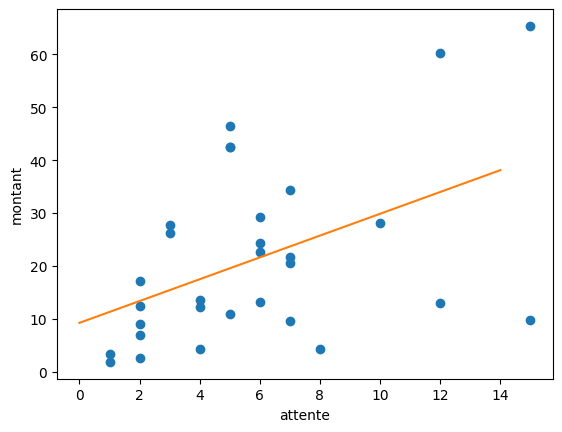

In [16]:
plt.plot(courses.attente,courses.montant, "o")
plt.plot(np.arange(15),[a*x+b for x in np.arange(15)])
plt.xlabel("attente")
plt.ylabel("montant")
plt.show()

attente      2.269582
intercept    8.377148
dtype: float64


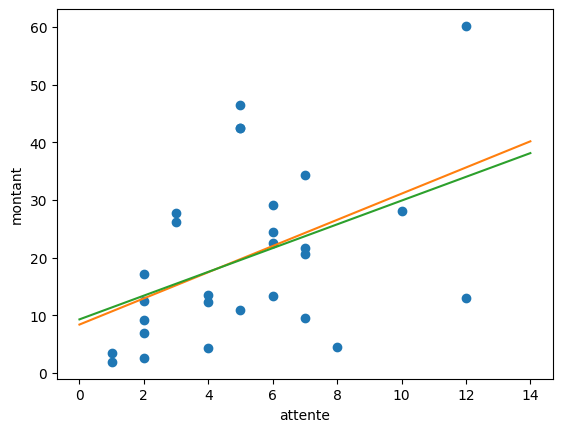

In [22]:
courses = courses.loc[courses['attente'] < 15, :]

Y = courses['montant']
X = courses[['attente']]
X = X.copy() # On modifiera X, on en crée donc une copie
X['intercept'] = 1.
result = sm.OLS(Y, X).fit() # OLS = Ordinary Least Square (Moindres Carrés Ordinaire)
a_new,b_new = result.params['attente'],result.params['intercept']

print(result.params)

plt.plot(courses.attente,courses.montant, "o")
plt.plot(np.arange(15),[a_new*x+b_new for x in np.arange(15)])
plt.plot(np.arange(15),[a*x+b for x in np.arange(15)])
plt.xlabel("attente")
plt.ylabel("montant")
plt.show()


## Analysez une variable quantitative et une qualitative par ANOVA

In [17]:
X = "categ" # qualitative
Y = "montant" # quantitative

# On ne garde que les dépenses
sous_echantillon = data[data["montant"] < 0].copy()
# On remet les dépenses en positif
sous_echantillon["montant"] = -sous_echantillon["montant"]
# On n'étudie pas les loyers car trop gros:
sous_echantillon = sous_echantillon[sous_echantillon["categ"] != "LOYER"] 

{'whiskers': [<matplotlib.lines.Line2D at 0x2806580d0>,
 'caps': [<matplotlib.lines.Line2D at 0x280658610>,
 'boxes': [<matplotlib.patches.PathPatch at 0x280593e80>,
 'medians': [<matplotlib.lines.Line2D at 0x280658b50>,
 'fliers': [],
 'means': [<matplotlib.lines.Line2D at 0x280658df0>,
  <matplotlib.lines.Line2D at 0x280693340>]}

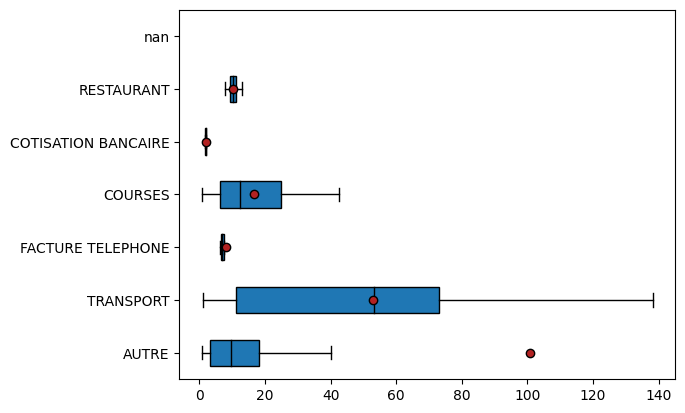

In [18]:
modalites = sous_echantillon[X].unique()
groupes = []
for m in modalites:
    groupes.append(sous_echantillon[sous_echantillon[X]==m][Y])

# Propriétés graphiques (pas très importantes)    
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}
    
plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)

In [23]:
X = "categ" # qualitative
Y = "montant" # quantitative

def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT

eta_squared(sous_echantillon[X],sous_echantillon[Y])

nan

## Analysez deux variables qualitatives avec le Chi-2

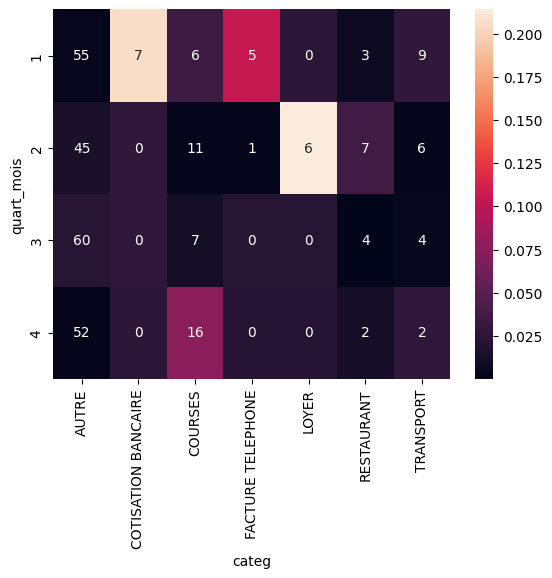

In [25]:
import seaborn as sns

X = "quart_mois"
Y = "categ"

cont = data[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len,margins=True,margins_name="Total")
cont

tx = cont.loc[:,["Total"]]
ty = cont.loc[["Total"],:]
n = len(data)
indep = tx.dot(ty) / n

c = cont.fillna(0) # On remplace les valeurs nulles par 0
measure = (c-indep)**2/indep
xi_n = measure.sum().sum()
table = measure/xi_n
sns.heatmap(table.iloc[:-1,:-1],annot=c.iloc[:-1,:-1])
plt.show()